In [13]:
!pip install tensorboard pandas -q
!pip install matplotlib seaborn -q
!pip install -U tbparse -q

In [16]:
from packaging import version

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb


from tbparse import SummaryReader


2025-05-19 08:12:12.002714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747642332.045222    1816 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747642332.056143    1816 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-19 08:12:12.091378: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [118]:
import numpy as np
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

def plot(log_dir, save_dir="default.jpg", print_batch=False, smoothing_weight=0.6):
    
    def smooth(x,window_len=11,window='hanning'):
        
        if x.ndim != 1:
            raise ValueError("smooth only accepts 1 dimension arrays.")
        if x.size < window_len:
            raise ValueError("Input vector needs to be bigger than window size.")
        if window_len<3:
            return x
        if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
            raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    
        s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    
        if window == 'flat': #moving average
            w=np.ones(window_len,'d')
        else:
            w=eval('np.'+window+'(window_len)')
    
        y=np.convolve(w/w.sum(),s,mode='valid')
        return y
            
    reader = SummaryReader(log_dir)
    df = reader.scalars
    train_loss = df[df["tag"] == "Loss/train"]["value"]
    valid_loss = df[df["tag"] == "Loss/val"]["value"]
    train_acc = df[df["tag"] == "Accuracy/train"]["value"]
    valid_acc = df[df["tag"] == "Accuracy/val"]["value"]
    epochs = list(range(len(valid_acc)))

    window_len = 11 if len(valid_acc)>11 else len(valid_acc)
    # Smooth the data
    smooth_train_loss = smooth(train_loss, window_len=window_len)
    smooth_valid_loss = smooth(valid_loss, window_len=window_len)
    smooth_train_acc = smooth(train_acc, window_len=window_len)
    smooth_valid_acc = smooth(valid_acc, window_len=window_len)
    start_plot = len(smooth_valid_acc)-len(epochs)


    # Adjust figure size based on whether we're showing batch metrics
    if print_batch:
        plt.figure(figsize=(18, 5))  # Wider figure to accommodate 3 plots
    else:
        plt.figure(figsize=(12, 5))  # Standard size for 2 plots

    # Plot loss on the first subplot
    plt.subplot(1, 3 if print_batch else 2, 1)
    plt.plot(epochs, train_loss, label='Training Loss', alpha=0.3)
    plt.plot(epochs, smooth_train_loss[start_plot:], label='Smoothed Train Loss', linewidth=2)
    plt.plot(epochs, valid_loss, label='Validation Loss', alpha=0.3)
    plt.plot(epochs, smooth_valid_loss[start_plot:], label='Smoothed Val Loss', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # Plot accuracy on the second subplot
    plt.subplot(1, 3 if print_batch else 2, 2)
    plt.plot(epochs, train_acc, label='Training Accuracy', alpha=0.3)
    plt.plot(epochs, smooth_train_acc[start_plot:], label='Smoothed Train Acc', linewidth=2)
    plt.plot(epochs, valid_acc, label='Validation Accuracy', alpha=0.3)
    plt.plot(epochs, smooth_valid_acc[start_plot:], label='Smoothed Val Acc', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    if print_batch:
        batch_acc = df[df["tag"] == "Accuracy/train_batch"]["value"]
        batch_loss = df[df["tag"] == "Loss/train_batch"]["value"]
        batch_steps = list(range(len(batch_loss)))
        
        # Smooth batch data
        smooth_batch_acc = smooth(batch_acc,window_len=160)
        smooth_batch_loss = smooth(batch_loss,window_len=160)
        start_plot = len(smooth_batch_loss)-len(batch_steps)

        
        # Plot batch metrics on the third subplot
        plt.subplot(1, 3, 3)
        plt.plot(batch_steps, batch_acc, label='Batch Accuracy', alpha=0.3)
        plt.plot(batch_steps, smooth_batch_acc[start_plot:], label='Smoothed Batch Acc', linewidth=2)
        plt.plot(batch_steps, batch_loss, label='Batch Loss', alpha=0.3)
        plt.plot(batch_steps, smooth_batch_loss[start_plot:], label='Smoothed Batch Loss', linewidth=2)
        plt.xlabel('Training Step')
        plt.ylabel('Metric Value')
        plt.title('Batch Training Metrics')
        plt.legend()

    plt.tight_layout()
    plt.savefig(save_dir)

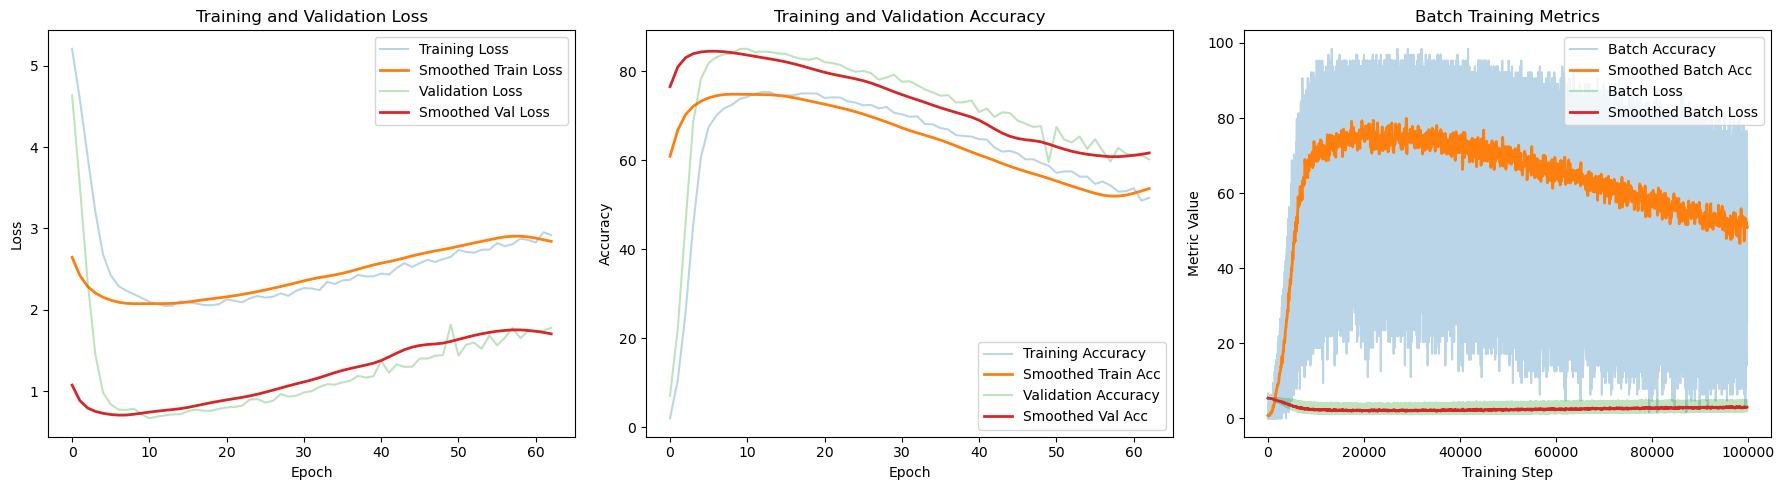

In [120]:
plot("scripts/runs/May18_21-43-00_673bab8e-c356-488b-8ab0-301a9c7a07aa", save_dir="interpolatedvit.jpg", print_batch=True, smoothing_weight=1)


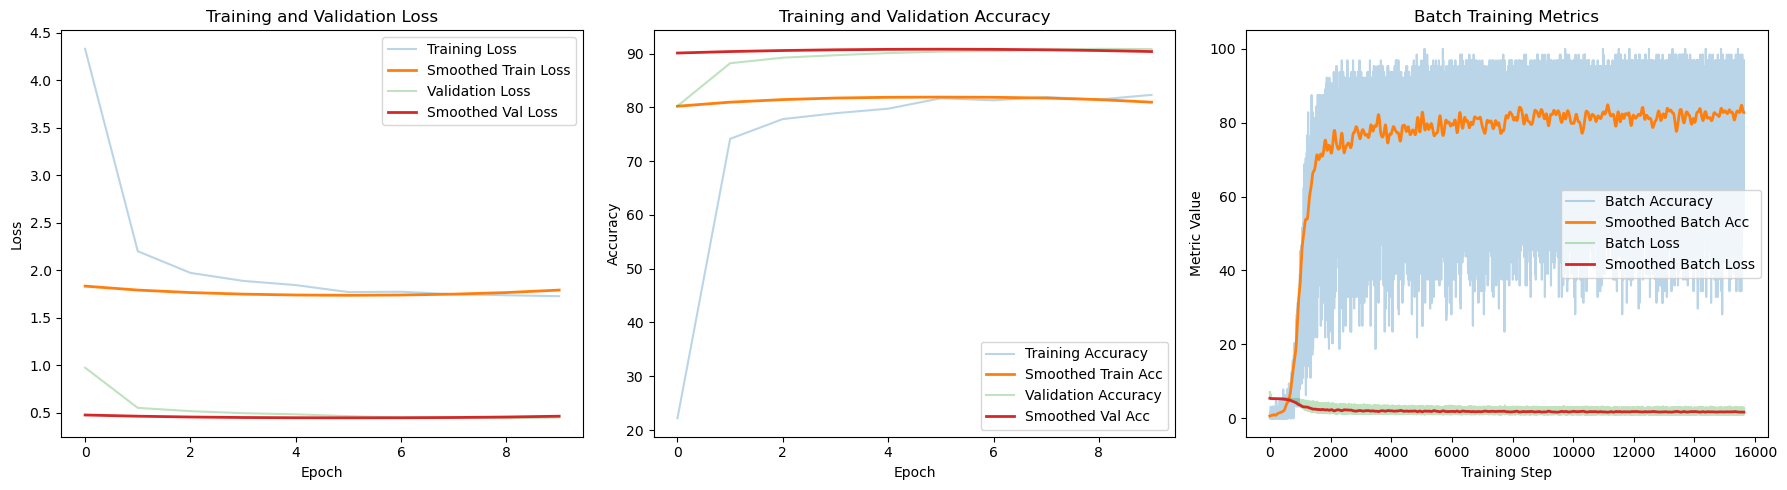

In [122]:
plot("scripts/runs/May18_00-21-59_673bab8e-c356-488b-8ab0-301a9c7a07aa", save_dir="defaultvit.jpg", print_batch=True, smoothing_weight=1)
